<a href="https://colab.research.google.com/github/Peeranatz/LiftingDetection/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
data = np.load("/content/drive/MyDrive/AI/datasets_action/skeleton_dataset_30frames.npz")
X = data["X"]
y = data["y"]

In [4]:
print(X.shape)
print(X[0].shape)
print(X[0][0]) # ดูตำแหน่งของ joint ในเฟรมที่ 0 ของตัวอย่างที่ 0
print(X[0][0][5]) # ดูตำแหน่งของ joint ที่ 5 (ของตัวอย่างที่ 0, เฟรมที่ 0)

(10421, 30, 19, 3)
(30, 19, 3)
[[-4.446557e-01 -1.109537e-01  3.722702e+00]
 [-4.355468e-01 -1.872923e-01  3.751457e+00]
 [-6.958012e-02  3.600657e-01  3.560644e+00]
 [-3.999168e-01 -1.616727e-01  3.741385e+00]
 [ 2.184692e-02 -2.641404e-01  3.714698e+00]
 [ 8.326545e-03 -1.204760e-01  3.740076e+00]
 [ 2.061151e-03 -1.911755e-01  3.736754e+00]
 [-2.854335e-01 -8.585055e-02  3.751582e+00]
 [-3.179240e-02 -1.886822e-01  3.724634e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00]
 [-3.206424e-01 -6.257299e-01  4.131803e+00]
 [-3.090612e-01 -7.101436e-01  4.031136e+00]
 [-1.419204e-01 -6.458485e-02  3.755912e+00]
 [-1.103935e-01 -6.322657e-01  4.133110e+00]
 [-1.004131e-01 -7.166198e-01  4.032369e+00]
 [-2.234268e-01  3.744705e-01  3.540335e+00]
 [-2.220007e-01  1.812761e-01  3.649263e+00]
 [-2.234811e-01  4.388770e-01  3.500978e+00]
 [-4.291614e-01 -2.660451e-01  3.769539e+00]]
[ 0.00832654 -0.120476    3.740076  ]


In [5]:
np.set_printoptions(precision=3, suppress=True)
print(X[0][0])  # joint ทั้งหมดในเฟรมแรกของตัวอย่างแรก

[[-0.445 -0.111  3.723]
 [-0.436 -0.187  3.751]
 [-0.07   0.36   3.561]
 [-0.4   -0.162  3.741]
 [ 0.022 -0.264  3.715]
 [ 0.008 -0.12   3.74 ]
 [ 0.002 -0.191  3.737]
 [-0.285 -0.086  3.752]
 [-0.032 -0.189  3.725]
 [ 0.     0.     0.   ]
 [-0.321 -0.626  4.132]
 [-0.309 -0.71   4.031]
 [-0.142 -0.065  3.756]
 [-0.11  -0.632  4.133]
 [-0.1   -0.717  4.032]
 [-0.223  0.374  3.54 ]
 [-0.222  0.181  3.649]
 [-0.223  0.439  3.501]
 [-0.429 -0.266  3.77 ]]


In [6]:
label_names = {0: 'standing', 1: 'moving', 2: 'carrying'}
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{label_names[label]} ({label}): {count}")

standing (0): 2822
moving (1): 2840
carrying (2): 4759


In [7]:
print(y.shape)
print(type(y[0]))

(10421,)
<class 'numpy.int64'>


In [8]:
# Reshape: Flatten joints (19,3) -> 57 features
X_reshaped = X.reshape(X.shape[0], X.shape[1], -1)
print(X_reshaped.shape)

(10421, 30, 57)


In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, stratify=y_temp)

In [10]:
print("X_train.shape:",X_train.shape)
print("X_val.shape:",X_val.shape)
print("X_test.shape:",X_test.shape)

X_train.shape: (7502, 30, 57)
X_val.shape: (834, 30, 57)
X_test.shape: (2085, 30, 57)


In [11]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(30, 57)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       190,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,347 (2.29 MB)

 Trainable params: 601,347 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8511 - loss: 0.3668 - val_accuracy: 0.8070 - val_loss: 0.4511
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8434 - loss: 0.3867 - val_accuracy: 0.8525 - val_loss: 0.4253
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8616 - loss: 0.3438 - val_accuracy: 0.8453 - val_loss: 0.4154
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8769 - loss: 0.3084 - val_accuracy: 0.8573 - val_loss: 0.3916
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8745 - loss: 0.3124 - val_accuracy: 0.8633 - val_loss: 0.3850
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8808 - loss: 0.2999 - val_accuracy: 0.8549 - val_loss: 0.3899
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8886 - loss: 0.2820 - val_accuracy: 0.8609 - val_loss: 0.3840
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8902 - loss: 0.2815 - 

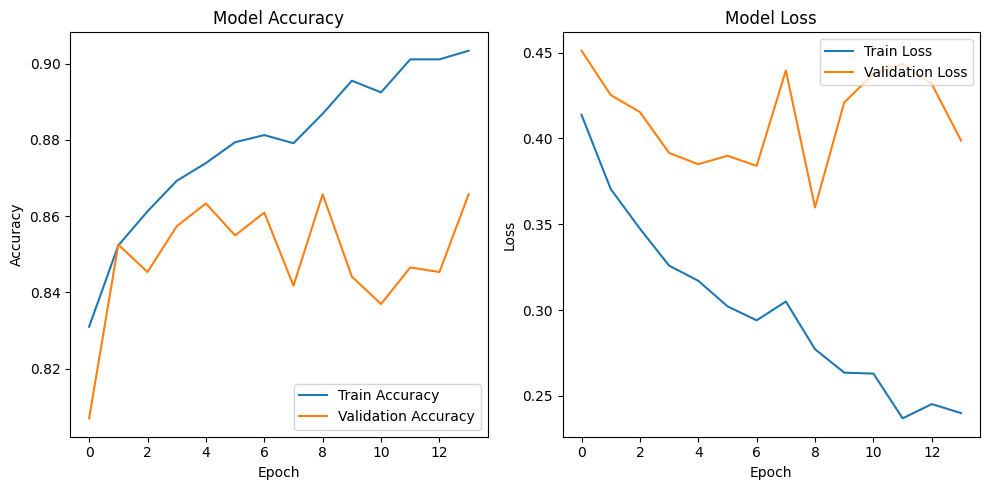

In [19]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training & Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
# Accuracy & Loss จาก history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# ค่าที่ดีที่สุด
best_train_acc = max(train_acc)
best_val_acc = max(val_acc)
best_train_loss = min(train_loss)
best_val_loss = min(val_loss)

# ปริ้นผล
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Best Training Accuracy: 0.9034
Best Training Loss: 0.2370
Best Validation Accuracy: 0.8657
Best Validation Loss: 0.3598


In [21]:
# ประเมินผลลัพธ์บน Test Set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8544 - loss: 0.3899
Test Loss: 0.3771
Test Accuracy: 0.8595


In [22]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_labels))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       565
           1       0.82      0.85      0.84       568
           2       0.88      0.89      0.88       952

    accuracy                           0.86      2085
   macro avg       0.86      0.85      0.85      2085
weighted avg       0.86      0.86      0.86      2085



In [23]:
# แสดงผลการทำนาย 10 ตัวอย่าง
print("ค่าจริง (y_test):", y_test[:10])
print("ค่าที่โมเดลทำนาย (y_pred):", y_pred_labels[:10])

ค่าจริง (y_test): [2 0 2 1 0 0 2 2 2 2]
ค่าที่โมเดลทำนาย (y_pred): [1 0 2 1 0 0 2 2 2 2]


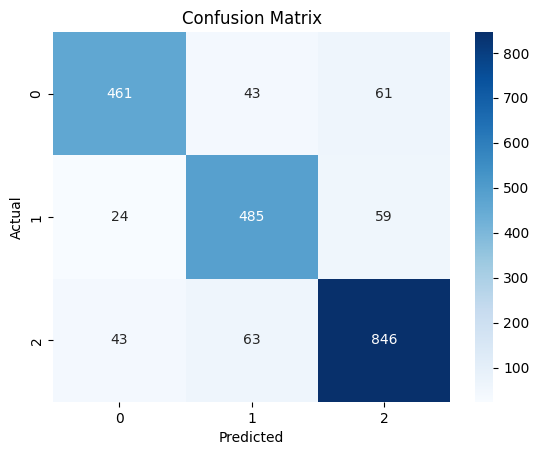

In [24]:
# แสดง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
model.save('/content/lstm_model.h5')